# NFL Player Value Analysis (2022–2024)

This project analyzes NFL player performance relative to salary across quarterbacks (QB), running backs (RB), and wide receivers (WR) using real scraped data from Pro Football Reference and OverTheCap. The goal is to evaluate player value using metrics like yards per dollar, Value Index, and predictive salary modeling.

In [543]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

## 1. Data Collection (Web Scraping)

This section gathers player salary and performance data from OverTheCap and Pro Football Reference for the 2022–2024 NFL seasons using Python-based web scraping.

In [544]:
# Scrape Salaries from QBs, RBs, and WRs from years 2022-2024
def scrape_salaries_multi(position, years=[2022, 2023, 2024]):
    from bs4 import BeautifulSoup
    import requests
    import pandas as pd

    position_map = {
        "QB": "quarterback",
        "RB": "running-back",
        "WR": "wide-receiver"
    }

    if position not in position_map:
        raise ValueError(f"Unsupported position: {position}")

    all_data = []

    for year in years:
        url = f"https://overthecap.com/position/{position_map[position]}/{year}"
        response = requests.get(url)
        soup = BeautifulSoup(response.content, "html.parser")
        table = soup.find("table")
        if not table:
            print(f"No salary table found for {position} in {year}")
            continue

        rows = table.find("tbody").find_all("tr")
        for row in rows[:35]:  # Top 35
            cols = row.find_all("td")
            if len(cols) >= 3:
                player = cols[0].get_text(strip=True)
                team = cols[1].get_text(strip=True)
                salary_str = cols[2].get_text(strip=True).replace("$", "").replace(",", "")
                try:
                    salary = float(salary_str)
                except ValueError:
                    salary = None  # Handle missing or non-numeric salary

                all_data.append([player, team, position, salary, year])

    return pd.DataFrame(all_data, columns=["Player", "Team", "Position", "Salary", "Year"])

In [545]:
# Collect salary data
qb_salary = scrape_salaries_multi("QB")
rb_salary = scrape_salaries_multi("RB")
wr_salary = scrape_salaries_multi("WR")
salary_df = pd.concat([qb_salary, rb_salary, wr_salary], ignore_index=True)

In [546]:
# Scrape player stats for QBs, RBs, and WRs for the years 2022-2024
def scrape_qb_stats_multi(years=[2022, 2023, 2024]):
    all_data = []
    for year in years:
        url = f"https://www.pro-football-reference.com/years/{year}/passing.htm"
        df = pd.read_html(url)[0]
        df = df[df['Player'] != 'Player']
        df = df[['Player', 'Team', 'Yds', 'TD', 'Cmp%']]
        df.columns = ['Player', 'Team', 'Passing_Yards', 'Pass_TDs', 'Completion_Pct']
        df["Year"] = year
        all_data.append(df)
    return pd.concat(all_data, ignore_index=True)

def scrape_rb_stats_multi(years=[2022, 2023, 2024]):
    all_data = []
    for year in years:
        url = f"https://www.pro-football-reference.com/years/{year}/rushing.htm"
        df = pd.read_html(url, header=1)[0]
        df = df[df["Player"] != "Player"]
        df = df[["Player", "Team", "Yds", "TD", "Y/A"]]
        df.columns = ["Player", "Team", "Rush_Yards", "Rush_TDs", "Yards_per_Carry"]
        df["Year"] = year
        df = df.apply(pd.to_numeric, errors='ignore')
        all_data.append(df)
    return pd.concat(all_data, ignore_index=True)

def scrape_wr_stats_multi(years=[2022, 2023, 2024]):
    all_data = []
    for year in years:
        url = f"https://www.pro-football-reference.com/years/{year}/receiving.htm"
        df = pd.read_html(url, header=1)[0]
        df.columns = [' '.join(col).strip() if isinstance(col, tuple) else col for col in df.columns]
        df = df[df["Player"] != "Player"]
        df = df[["Player", "Team", "Yds", "TD", "Y/R"]]
        df.columns = ["Player", "Team", "Receiving_Yards", "Receiving_TDs", "Yards_per_Catch"]
        df["Year"] = year
        df = df.apply(pd.to_numeric, errors='ignore')
        all_data.append(df)
    return pd.concat(all_data, ignore_index=True)

# Run scrapers
qb_stats = scrape_qb_stats_multi()
rb_stats = scrape_rb_stats_multi()
wr_stats = scrape_wr_stats_multi()

C:\Users\aterrill\AppData\Local\Temp\ipykernel_15472\1471735060.py:23: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')
C:\Users\aterrill\AppData\Local\Temp\ipykernel_15472\1471735060.py:23: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')
C:\Users\aterrill\AppData\Local\Temp\ipykernel_15472\1471735060.py:23: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')
C:\Users\aterrill\AppData\Local\Temp\ipykernel_15472\1471735060.py:37: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_n

## 2. Data Cleaning and Merging

This section merges scraped salary and performance data by player and year, fills missing values, and prepares a unified dataset for analysis.

In [547]:
# 3. Merge Salary with Stats
qb_merged = pd.merge(qb_salary, qb_stats, on='Player', how='left')
rb_merged = pd.merge(rb_salary, rb_stats, on='Player', how='left')
wr_merged = pd.merge(wr_salary, wr_stats, on='Player', how='left')
combined_df = pd.concat([qb_merged, rb_merged, wr_merged], ignore_index=True)

In [548]:
# 4. Value Index Calculation
combined_df["Salary_M"] = combined_df["Salary"] / 1_000_000
combined_df["Yards"] = (
    combined_df["Passing_Yards"].fillna(0) +
    combined_df["Rush_Yards"].fillna(0) +
    combined_df["Receiving_Yards"].fillna(0)
)
combined_df["Value_Index"] = combined_df["Yards"] / combined_df["Salary_M"]

In [549]:
# Step 1: Combine QB, RB, WR stats
performance_df = pd.concat([qb_stats, rb_stats, wr_stats], ignore_index=True)

# Step 2: Combine salary data (if you haven't already)
salary_df = pd.concat([qb_salary, rb_salary, wr_salary], ignore_index=True)

# Step 3: Strip whitespace from player names (helps with merging)
performance_df["Player"] = performance_df["Player"].str.strip()
salary_df["Player"] = salary_df["Player"].str.strip()

# Step 4: Merge on Player and Year
merged_df = pd.merge(performance_df, salary_df, on=["Player", "Year"], how="inner")

## 3. Feature Engineering

This section creates key metrics such as Stat_Total, Normalized_Stat, Normalized_Salary, Value Index, and Normalized Yards per Dollar to enable consistent comparison of player performance and compensation.

In [550]:
for col in ["Passing_Yards", "Rush_Yards", "Receiving_Yards", "Pass_TDs", "Rush_TDs", "Receiving_TDs"]:
    if col in merged_df.columns:
        merged_df[col] = merged_df[col].fillna(0)

# Calculate total performance with TD weighting
merged_df["Stat_Total"] = (
    merged_df["Passing_Yards"] +
    merged_df["Rush_Yards"] +
    merged_df["Receiving_Yards"] +
    merged_df["Pass_TDs"] * 20 +
    merged_df["Rush_TDs"] * 20 +
    merged_df["Receiving_TDs"] * 20
)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
merged_df["Normalized_Salary"] = scaler.fit_transform(merged_df[["Salary"]])
merged_df["Normalized_Stat"] = scaler.fit_transform(merged_df[["Stat_Total"]])

# Calculate Value Index
merged_df["Value_Index"] = merged_df["Normalized_Stat"] - merged_df["Normalized_Salary"]

In [551]:
# Drop rows where salary or stat is missing
merged_df = merged_df.dropna(subset=["Salary", "Stat_Total"])

## 4. Value Analysis and Visualization

This section explores player value using normalized performance and salary metrics. Visualizations highlight top and bottom performers, as well as positional efficiency based on Value Index and normalized yards per dollar.

### Scatter Plot: Salary vs. Total Yards (2022–2024)

This scatter plot compares player salaries to their total yardage (rushing, receiving, or passing) across the 2022–2024 seasons. Each dot represents one player-season and is color-coded by position. This visualization helps reveal the general relationship between pay and performance, as well as how it varies by position.

In [552]:
scaler = MinMaxScaler()
merged_df["Normalized_Stat"] = scaler.fit_transform(merged_df[["Stat_Total"]])
merged_df["Normalized_Salary"] = scaler.fit_transform(merged_df[["Salary"]])

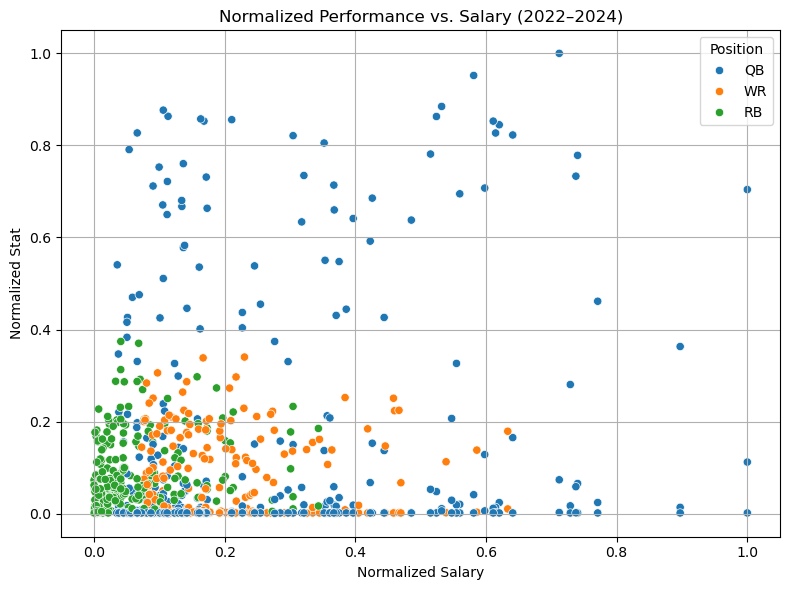

In [553]:
# Scatter Plot: Salary vs. Total Yards
plt.figure(figsize=(8, 6))
sns.scatterplot(data=merged_df, x="Normalized_Salary", y="Normalized_Stat", hue="Position")
plt.title("Normalized Performance vs. Salary (2022–2024)")
plt.xlabel("Normalized Salary")
plt.ylabel("Normalized Stat")
plt.grid(True)
plt.tight_layout()
plt.show()

### Average Yards per $1M by Position

This bar chart displays the average number of total yards generated per $1 million in salary for each position group (QB, RB, WR) from 2022 to 2024. By calculating a player's total performance (passing, rushing, or receiving yards) relative to their salary, we can assess how much on-field production each position delivers per dollar spent.

Higher bars represent greater efficiency, or better "value for money." This visualization supports the project's goal of comparing player compensation to on-field performance by identifying which positions tend to deliver more production per dollar.

In [554]:
# Normalized yards per normalized million dollars
merged_df["Normalized_Yards_per_Million"] = merged_df["Normalized_Stat"] / merged_df["Normalized_Salary"]

C:\Users\aterrill\AppData\Local\Temp\ipykernel_15472\1736922344.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=merged_df, x="Position", y="Normalized_Yards_per_Million", estimator="mean", palette="viridis")


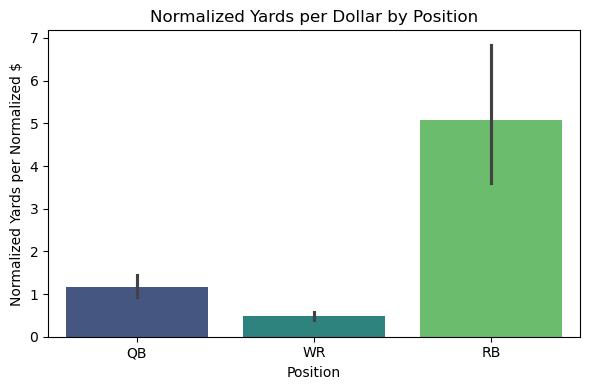

In [555]:
# Bar Chart: Average Value Index by Position
plt.figure(figsize=(6, 4))
sns.barplot(data=merged_df, x="Position", y="Normalized_Yards_per_Million", estimator="mean", palette="viridis")
plt.title("Normalized Yards per Dollar by Position")
plt.ylabel("Normalized Yards per Normalized $")
plt.xlabel("Position")
plt.tight_layout()
plt.show()

### Top 10 Players by Value Index
This plot shows the ten players who delivered the highest performance relative to their salary across all positions and years. A higher Value Index means better "bang for the buck."

C:\Users\aterrill\AppData\Local\Temp\ipykernel_15472\4101249350.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Value_Index", y="Player_Year", data=top_10, palette="Greens")


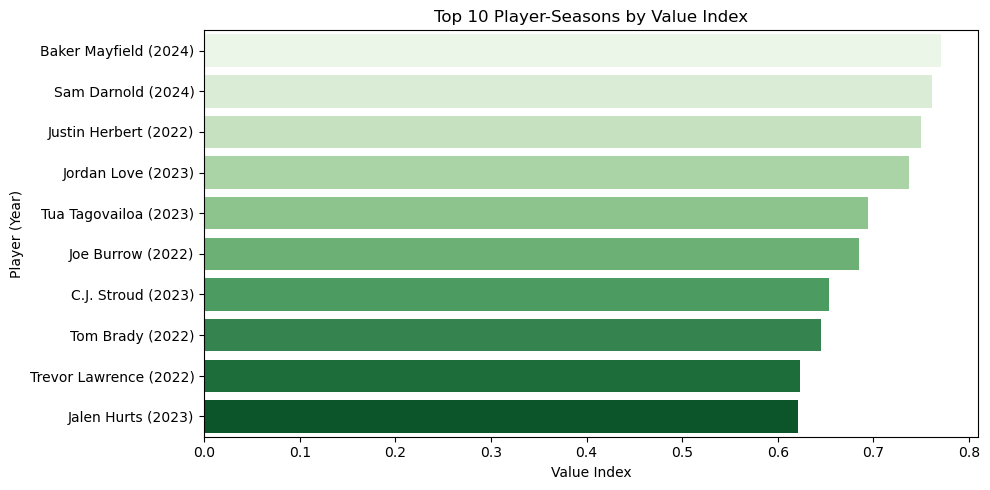

In [556]:
# Combine Player and Year into one column for uniqueness
merged_df["Player_Year"] = merged_df["Player"] + " (" + merged_df["Year"].astype(str) + ")"

# Sort by Value Index and get top 10 INCLUDING duplicates
top_10 = merged_df.sort_values(by="Value_Index", ascending=False).head(10)

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x="Value_Index", y="Player_Year", data=top_10, palette="Greens")
plt.title("Top 10 Player-Seasons by Value Index")
plt.xlabel("Value Index")
plt.ylabel("Player (Year)")
plt.tight_layout()
plt.show()

### Bottom 10 Players by Value Index
This plot highlights the players who received high salaries but underperformed relative to that compensation. A lower (or negative) Value Index indicates inefficiency or overvaluation.

C:\Users\aterrill\AppData\Local\Temp\ipykernel_15472\2881126809.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Value_Index", y="Player_Label", data=bottom_10, palette="Reds_r")


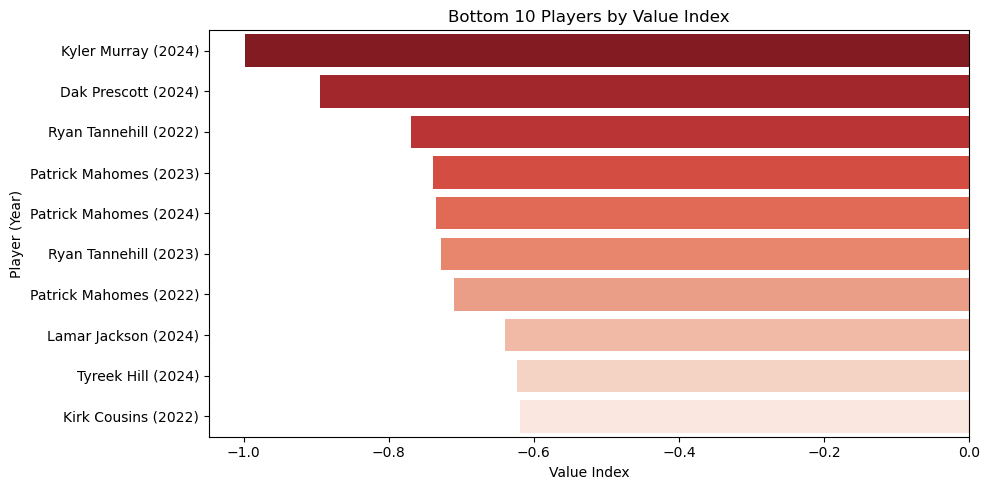

In [557]:
bottom_10 = (
    merged_df
    .sort_values(by="Value_Index")
    .drop_duplicates(subset=["Player", "Year"])
    .head(10)
)

bottom_10["Player_Label"] = bottom_10["Player"] + " (" + bottom_10["Year"].astype(str) + ")"

plt.figure(figsize=(10, 5))
sns.barplot(x="Value_Index", y="Player_Label", data=bottom_10, palette="Reds_r")
plt.title("Bottom 10 Players by Value Index")
plt.xlabel("Value Index")
plt.ylabel("Player (Year)")
plt.tight_layout()
plt.show()

## 5. Hypothesis Testing

This section compares the Value Index between quarterbacks (QBs) and running backs (RBs) using Welch’s t-test to determine if

In [558]:
# Filter out missing or NaN values
qb_values = combined_df[(combined_df["Position"] == "QB") & (combined_df["Value_Index"].notna())]["Value_Index"]
rb_values = combined_df[(combined_df["Position"] == "RB") & (combined_df["Value_Index"].notna())]["Value_Index"]

# Perform Welch's t-test (does not assume equal variances)
t_stat, p_val = ttest_ind(qb_values, rb_values, equal_var=False)

# Print the results
print(f"T-statistic: {t_stat:.2f}")
print(f"P-value: {p_val:.4f}")

T-statistic: 3.71
P-value: 0.0002


In [559]:
# Save the final combined data to an Excel file
combined_df.to_excel("NFL_2024_Salary_Performance.xlsx", index=False)

## 6. Machine Learning – Regression Models
In this section, we use Linear Regression, Ridge Regression, and Lasso Regression to predict player salary based on performance stats from the 2022–2024 seasons. Features are normalized before model training.

In [560]:
# Predict salary using total stat output
# One-hot encode the Position column
merged_encoded = pd.get_dummies(merged_df, columns=["Position"], drop_first=True)

# Automatically include all one-hot encoded position columns
position_cols = [col for col in merged_encoded.columns if col.startswith("Position_")]

# Define feature matrix and target
X = merged_encoded[["Stat_Total", "Normalized_Stat", "Year"] + position_cols]
y = merged_encoded["Salary"]

# Standardize the feature
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train models
lr = LinearRegression().fit(X_train, y_train)
lr_preds = lr.predict(X_test)

ridge = Ridge(alpha=1).fit(X_train, y_train)
ridge_preds = ridge.predict(X_test)

lasso = Lasso(alpha=0.1).fit(X_train, y_train)
lasso_preds = lasso.predict(X_test)

# Evaluation
print("Linear Regression R²:", r2_score(y_test, lr_preds))
print("Ridge Regression R²:", r2_score(y_test, ridge_preds))
print("Lasso Regression R²:", r2_score(y_test, lasso_preds))

print("Linear MAE: $", round(mean_absolute_error(y_test, lr_preds), 0))
print("Ridge MAE: $", round(mean_absolute_error(y_test, ridge_preds), 0))
print("Lasso MAE: $", round(mean_absolute_error(y_test, lasso_preds), 0))

Linear Regression R²: 0.22141606717684514
Ridge Regression R²: 0.22144754830450986
Lasso Regression R²: 0.2214160649976591
Linear MAE: $ 5442159.0
Ridge MAE: $ 5442350.0
Lasso MAE: $ 5442159.0


### Predicted vs. Actual Salary (Linear Regression)

This scatter plot compares the predicted player salaries (from the linear regression model) to the actual salaries in the test set. Each point represents one player, and the red dashed line indicates perfect prediction. 

The closer the points are to this line, the more accurate the model. This visualization helps evaluate the model's ability to estimate salary based on receiving yards, touchdowns, and yards per catch.

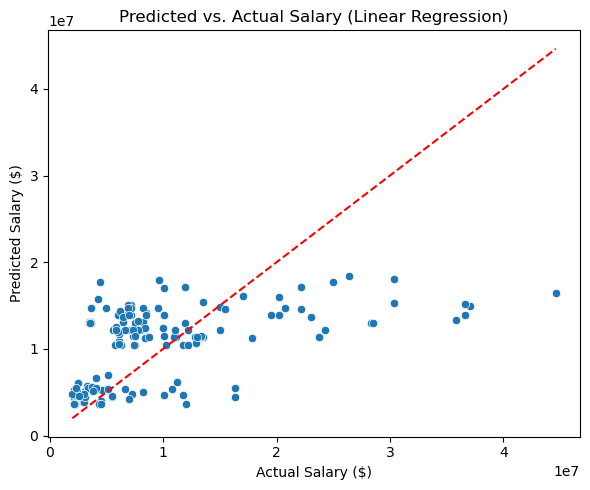

In [561]:
# Scatter Plot: Predicted vs. Actual Salary
plt.figure(figsize=(6, 5))
sns.scatterplot(x=y_test, y=lr_preds)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # 45-degree reference line
plt.title("Predicted vs. Actual Salary (Linear Regression)")
plt.xlabel("Actual Salary ($)")
plt.ylabel("Predicted Salary ($)")
plt.tight_layout()
plt.show()

## Final Conclusion

This analysis revealed that running backs (RBs) tend to offer the most value per dollar when compared to QBs and WRs, based on total production vs. salary. The Value Index and Yards per $1M metrics showed clear differences in positional efficiency.

The hypothesis test found a statistically significant difference between QBs and RBs (t = 3.71, p = 0.0002), indicating that the two positions differ meaningfully in average Value Index.

Machine learning models (Linear, Ridge, Lasso) achieved modest accuracy (R² ≈ 0.22), suggesting that while performance helps predict salary, other unmeasured factors also play a large role.

This project highlights how scraping, cleaning, merging, and modeling real-world sports data can uncover valuable insights into player efficiency and market value.

In [562]:
# Save the generated dataset
df.to_csv("NFL_Combined_2022_2024.csv", index=False)
print("Saved combined dataset as NFL_Combined_2022_2024.csv")

Saved combined dataset as NFL_Combined_2022_2024.csv
